# Session 04 Homework

The goal of this homework is to create a classification model for determining if a bank client will subscribe a term deposit or not.

In [3]:
# Necessary import
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

## Get Data
We will use the `bank/bank-full.csv` file from the downloaded zip-file of the [Bank Marketing dataset](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

In [5]:
# zip data url
bank_data = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"

In [6]:
# Get the zip-file
!wget $bank_data

In [7]:
# Unzip the `bank+marketing.zip` file
with zipfile.ZipFile('bank+marketing.zip', 'r') as bank_market:
    bank_market.extractall('') # extracting all files to current directory

We should first check the files available:

In [9]:
ls

 Le volume dans le lecteur C n’a pas de nom.
 Le numéro de série du volume est 2EFA-F61A

 Répertoire de C:\Users\dell\Videos\Elearning\Data Science\ML_Zoomcamp\ML_Zoomcamp_2024\04_evaluation\notebooks

21/10/2024  14:57    <DIR>          .
21/10/2024  14:57    <DIR>          ..
21/10/2024  14:51    <DIR>          .ipynb_checkpoints
21/10/2024  14:57           579 043 bank.zip
15/10/2024  11:53         1 023 843 bank+marketing.zip
21/10/2024  14:57           444 572 bank-additional.zip
18/10/2024  13:21           977 501 data-week-3.csv
20/10/2024  17:12           293 814 evaluation_metrics.ipynb
21/10/2024  14:55            81 010 homework_session_04.ipynb
               6 fichier(s)        3 399 783 octets
               3 Rép(s)  374 827 921 408 octets libres


Now, we can extract the dataset `bank-full.csv` from the `bank.zip` file:

In [11]:
# Extract only the `bank-full.csv` file
with zipfile.ZipFile('bank.zip', 'r') as bank:
    bank.extract('bank-full.csv', '') # extracting dataset to current directory

After extraction, let's read the data:

In [13]:
# Read the dataframe
df = pd.read_csv("bank-full.csv", sep = ";")

# Three last rows
df.tail(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


## Data Preparation

### Target encoding

Let's encode the `y` variable, replacing the values *yes*/*no* with *1*/*0*:

In [16]:
# Encoding `yes`/`no` to numerical values
df.y = (df.y == "yes").astype(int)

# Three last rows
df.tail(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,0


For the rest of the homework, we'll need only use these columns:
* `age`,
* `job`,
* `marital`,
* `education`,
* `balance`,
* `housing`,
* `contact`,
* `day`,
* `month`,
* `duration`,
* `campaign`,
* `pdays`,
* `previous`,
* `poutcome`,
* `y`
 
Let's subset our dataset:

In [18]:
# Select relevant features
subset = ["age", "job", "marital", "education", "balance", "housing", "contact", "day",
          "month", "duration", "campaign", "pdays", "previous", "poutcome", "y"]

# Create a subset of data
df = df[subset]

Let's get info about the data:

In [20]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  int32 
dtypes: int32(1), int64(7), object(7)
memory usage: 5.0+ MB


### Split the data

 We will split the data into train/val/test sets with 60%/20%/20% distribution using Scikit-Learn (`train_test_split` function) with a seed of `1`:

In [22]:
# Splitting into full train and test
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)

# Splitting into train and test
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [23]:
# Check datasets sizes after splitting
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [24]:
# Reset indexes
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)

Let's extract the target variable `y` from our dataframe:

In [26]:
# Get the target values
y_train = df_train.y.values
y_test = df_test.y.values
y_val = df_val.y.values

# Drop `y` from our data sets
del df_train["y"]
del df_test["y"]
del df_val["y"]

### Question 1: ROC AUC feature importance

We will use ROC AUC to evaluate feature importance of numerical variables. Using the training dataset, we compute the AUC of each numerical variable with the `y` variable as ground truth. If an AUC is < 0.5, we will invert this variable by putting "-" in front (e.g. `-df_train['engine_hp']`). Note that AUC can go below 0.5 if the variable is negatively correlated with the target variable. Negating this variable helps change the direction of the correlation for negative correlation to become positive.

In [28]:
# Numerial features list
num_features = df_train.select_dtypes("number").columns.to_list()

# Initialize scores
feat_imp = []

# Get Feature importance using AUC
for feat in num_features:
    # Compute auc score
    feat_auc = roc_auc_score(y_train, df_train[feat])

    # Invert variable for low AUC
    if feat_auc < 0.5:
        feat_auc = roc_auc_score(y_train, -df_train[feat])

    # Append rounded score
    feat_imp += [round(feat_auc, 3)]

# Series for feature importance scores
feat_scores = pd.Series(feat_imp, index = num_features, name = "feature_importance")

# Sorted feature importance
feat_scores.sort_values(ascending = False)

duration    0.815
previous    0.599
pdays       0.590
balance     0.589
campaign    0.571
day         0.526
age         0.512
Name: feature_importance, dtype: float64

The numerical variable among `balance`, `day`, `duration` and `previous` with the highest AUC is `duration`.

### Question 2: Training the model

Let's apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000).
```

To do so, we will define a function for model training and another one, to make predictions.

In [31]:
# Function for training a logistic regression model
def train(df_train, y_train, C = 1.0):
    # Convert data to list of dictionaries
    dicts = df_train.to_dict(orient = 'records')

    # Initialize One-Hot-Encoder
    One_Hot_Enc = DictVectorizer(sparse = False)
    # One-Hot-Encoding
    X_train = One_Hot_Enc.fit_transform(dicts)

    # Initialize Logistic Regression model
    logistic_model = LogisticRegression(solver = 'liblinear', C = C, max_iter = 1000)
    # Model training
    logistic_model.fit(X_train, y_train)

    # return logistic regression model and One-Hot-Encoder
    return One_Hot_Enc, logistic_model

# Function to make predictions
def predict(df, One_Hot_Enc, logistic_model):
    # Convert data to list of dictionaries
    dicts = df.to_dict(orient = 'records')

    # One-Hot-Encoding
    X = One_Hot_Enc.transform(dicts)
    # Make soft predictions
    y_pred = logistic_model.predict_proba(X)[:, 1]

    # return predictions
    return y_pred

In [32]:
# Model training
One_Hot_Enc, logistic_model = train(df_train, y_train)

# Make soft predictions
y_pred = predict(df_val, One_Hot_Enc, logistic_model)
y_pred

# Rounded AUC score
round(roc_auc_score(y_val, y_pred), 3)

0.9

The rounded AUC of this model on the validation dataset is `0.89`.

### Question 3: Precision and Recall

Now let's compute precision and recall for our model. We first evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01, and for each threshold, we compute precision and recall. We will define a function for that and finaly, we plot all scores.

In [35]:
# Function for returning a model precision and recall scores
def tpr_fpr_dataframe(y_val, y_pred):
    # Initialize scores
    scores = []

    # List of thresholds
    thresholds = np.linspace(0, 1, 101)

    # Tuning with possible thresholds
    for t in thresholds:
        # Real values
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        # Model's predictions
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        # Count of true positives (tp) and true negatives (tn)
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        # Count of false positives (fp) and false negatives (fn)
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        # Store scores
        scores.append((tp, fp, fn, tn))

    # Columns names
    columns = ['tp', 'fp', 'fn', 'tn']
    # Create dataframe for storing results
    df_scores = pd.DataFrame(scores, columns = columns, index = thresholds)
    
    # Compute precision and recall metrics
    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

    # return result
    return df_scores

In [36]:
# Dataframe result
df_results = tpr_fpr_dataframe(y_val, y_pred)

# See some values (skipping 10 observations each time)
df_results[ : : 10]

,tp,fp,fn,tn,precision,recall
0.0,1098,7944,0,0,0.121433,1.000000
0.1,926,1494,172,6450,0.382645,0.843352
0.2,711,691,387,7253,0.507133,0.647541
0.3,565,412,533,7532,0.578301,0.514572
0.4,459,273,639,7671,0.627049,0.418033
0.5,371,193,727,7751,0.657801,0.337887
0.6,290,137,808,7807,0.679157,0.264117
0.7,224,102,874,7842,0.687117,0.204007
0.8,148,69,950,7875,0.682028,0.134791
0.9,77,28,1021,7916,0.733333,0.070128


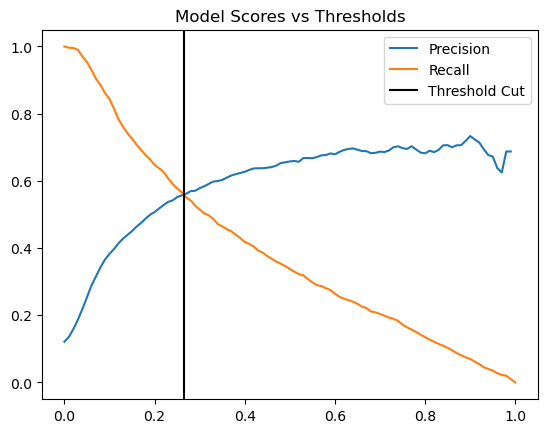

In [37]:
# Plot model precision score
plt.plot(df_results.index, df_results.precision, label = 'Precision')
# Plot model recall score
plt.plot(df_results.index, df_results.recall, label = 'Recall')

# Intersection line
plt.axvline(x = 0.265, color = "black", label = "Threshold Cut")

# Title
plt.title("Model Scores vs Thresholds")
# legend
plt.legend();

The threshold at which precision and recall curves intersect is `0.265`.

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both. This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01:

In [40]:
# Compute F1 scores
df_results["F1_score"] = 2 * (df_results.precision * df_results.recall) / (df_results.precision + df_results.recall)

# Get the threshold with the maximum F1 score
df_results["F1_score"].idxmax()

0.22

The threshold at which F1 is maximal is `0.22`.

### Question 5: 5-Fold CV

Let's use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits = 5, shuffle = True, random_state = 1)
```
We will iterate over different folds of `df_full_train`, splitting the data into train and validation, to train the model on the training set with the following parameters: `LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000)` and evaluate it on validation set with AUC.

In [43]:
# Number of splits
n_splits = 5

# Kfold cross-validation
kfold = KFold(n_splits = n_splits, shuffle = True, random_state = 1)

# Initialize scores
scores = []

# For each iteration of K-fold split and the pair of indexes generated
for train_idx, val_idx in kfold.split(df_full_train):
    # Select train and validation data
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    # Select target variables
    y_train = df_train.y.values
    y_val = df_val.y.values

    # Drop leakage variables (targets)
    df_train = df_train.drop(columns = "y")
    df_val = df_val.drop(columns = "y")
    
    # Train model
    One_Hot_Enc, logistic_model = train(df_train, y_train)
    # Make predictions
    y_pred = predict(df_val, One_Hot_Enc, logistic_model)

    # Get score
    auc = roc_auc_score(y_val, y_pred)
    # Store score
    scores.append(auc)

# Print scores' standard deviation
print('std = +- %.3f' % np.std(scores))

std = +- 0.005


The standard deviation of the scores across different folds is approximately `0.006`.

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`. We will iterate over the following `C` values: `[0.000001, 0.001, 1]`, initializing `KFold` with the same parameters as previously,  and using these parameters for the model: `LogisticRegression(solver = 'liblinear', C = C, max_iter = 1000)`, to compute the rounded mean score as well as the rounded std.

In [46]:
# Number of splits
n_splits = 5

# List of parameters
tun_params = [0.000001, 0.001, 1]

# Parameter (C -> regularization) fine-tuning
for C in tun_params:
    # Kfold cross-validation
    kfold = KFold(n_splits = n_splits, shuffle = True, random_state = 1)

    # Initialize scores
    scores = []

    # For each iteration of K-fold split and the pair of indexes generated
    for train_idx, val_idx in kfold.split(df_full_train):
        # Select train and validation data
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        # Select target variables
        y_train = df_train.y.values
        y_val = df_val.y.values
    
        # Drop leakage variables (targets)
        df_train = df_train.drop(columns = "y")
        df_val = df_val.drop(columns = "y")
        
        # Train model
        One_Hot_Enc, logistic_model = train(df_train, y_train, C = C)
        # Make predictions
        y_pred = predict(df_val, One_Hot_Enc, logistic_model)
    
        # Get score
        auc = roc_auc_score(y_val, y_pred)
        # Store score
        scores.append(auc)

    # Print results
    print('C = %s, mean = %.3f, std = +- %.3f' % (C, np.mean(scores), np.std(scores)))

C = 1e-06, mean = 0.701, std = +- 0.009
C = 0.001, mean = 0.861, std = +- 0.007
C = 1, mean = 0.906, std = +- 0.005


The `C` leading to the best mean score is `1`.

---